In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-11-06 21:49:22--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-06 21:49:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: 'jamb_exam_results.csv'

     0K .......... .......... .......... .......... .......... 13% 3.47M 0s
    50K .......... .......... ..........

In [3]:
df = pd.read_csv('jamb_exam_results.csv')
df

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,183,20,74,2,10.6,Public,Urban,Yes,No,Low,Low,4996,16,Male,Medium,Primary,2
4996,179,0,80,2,20.0,Public,Rural,No,Yes,Medium,Medium,4997,22,Male,Low,Secondary,1
4997,261,17,89,3,11.3,Public,Urban,No,No,Low,High,4998,18,Male,Medium,Primary,3
4998,183,15,96,2,15.9,Public,Rural,No,No,Low,Medium,4999,18,Male,Medium,Secondary,1


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')


In [5]:
del df['student_id']

In [7]:
df=df.fillna(0)

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

In [13]:
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [14]:
from sklearn.feature_extraction import DictVectorizer

In [15]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [16]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

In [17]:
from sklearn.tree import DecisionTreeRegressor

In [18]:
dt=DecisionTreeRegressor(max_depth=1)

In [20]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
from sklearn.tree import export_text

In [22]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



R: Study Hours per week.

## Question 2

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)

In [25]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [33]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [34]:
y_pred = rf.predict(X_val)

In [35]:
rmse(y_pred,y_val)

42.13724207871227

R: 42.13

## Question 3

In [36]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_s = rmse(y_val, y_pred)
    
    scores.append((n, rmse_s))

In [37]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

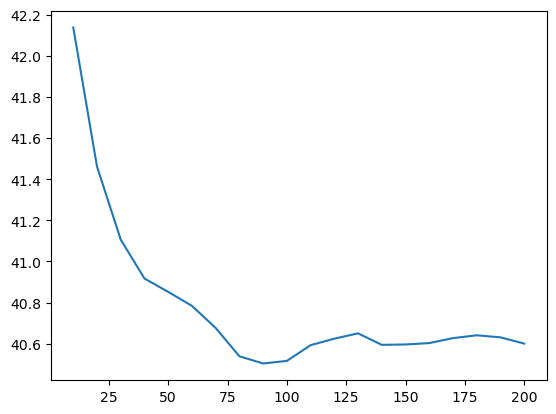

In [38]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [39]:
df_scores

,n_estimators,rmse
0,10,42.137242
1,20,41.461215
2,30,41.106171
3,40,40.917194
4,50,40.852279
5,60,40.784281
6,70,40.677098
7,80,40.539333
8,90,40.504346
9,100,40.516805


R: 80

## Question 4

In [40]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse_s= rmse(y_val, y_pred)

        scores.append((d, n, rmse_s))

In [41]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

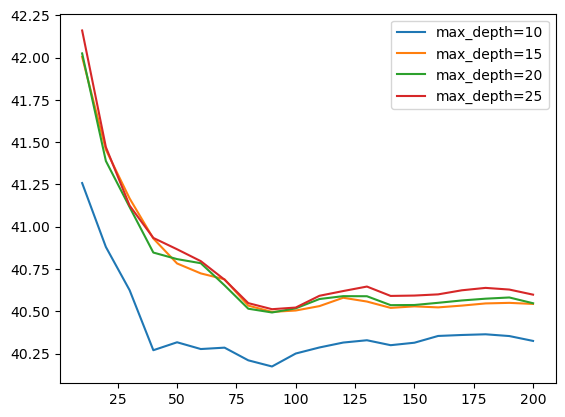

In [43]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

R: max_depth=25

## Question 5

In [44]:
rf=RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

<Axes: >

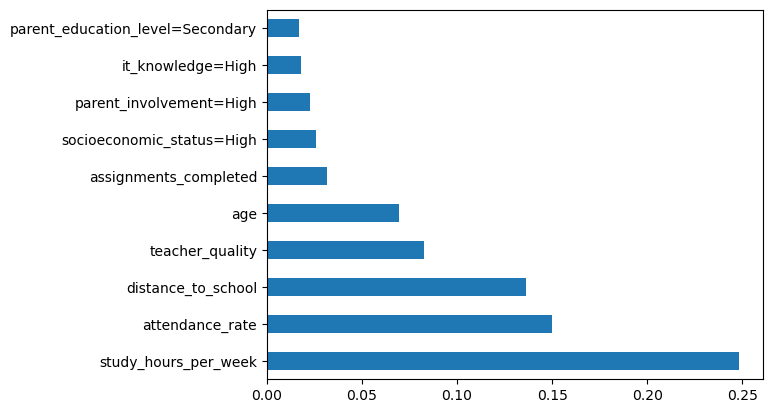

In [50]:
feat_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names_out())
feat_importances.nlargest(10).plot(kind='barh')

R: Study hours per week

## Question 6

In [51]:
import xgboost as xgb

In [52]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [53]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [55]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [56]:
y_pred = model.predict(dval)

In [57]:
rmse(y_pred, y_val)

43.418817345871766

In [58]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [59]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [60]:
y_pred = model.predict(dval)

In [61]:
rmse(y_pred, y_val)

41.05034017683498

R: Eta=0.1 best